<div style="text-align: center; color:royalblue;">
    <h1>Project: Prediction of Natural Disaster Intensity in the United States 💥</h1>
    <h3>Using Hailstorm and Thunderstorm Wind data</h3>
    <h3 style="color:green;">Data history: 2006, 2018 - 2021</h3>
</div>

## Libraries

In [56]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

## Configurations

In [57]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)

In [58]:

base = "./storm_data/"
files = ["StormEvents_details-database_v1.0_d2006_c20210603",
"StormEvents_details-database_v1.0_d2018_c20210604",
"StormEvents_details-database_v1.0_d2019_c20210604",
"StormEvents_details-database_v1.0_d2020_c20210604",
"StormEvents_details-database_v1.0_d2021_c20210607"]

df_og = pd.concat([pd.read_csv(f"{base}{file}.csv") for file in files])
df_og.head()

C:\Users\maxag\AppData\Local\Temp\ipykernel_3252\220933920.py:8: DtypeWarning: Columns (29,34,35,37,48,55,56) have mixed types. Specify dtype option on import or set low_memory=False.
  df_og = pd.concat([pd.read_csv(f"{base}{file}.csv") for file in files])


,BEGIN_YEARMONTH,BEGIN_DAY,BEGIN_TIME,END_YEARMONTH,END_DAY,END_TIME,EPISODE_ID,EVENT_ID,STATE,STATE_FIPS,YEAR,MONTH_NAME,EVENT_TYPE,CZ_TYPE,CZ_FIPS,CZ_NAME,WFO,BEGIN_DATE_TIME,CZ_TIMEZONE,END_DATE_TIME,INJURIES_DIRECT,INJURIES_INDIRECT,DEATHS_DIRECT,DEATHS_INDIRECT,DAMAGE_PROPERTY,DAMAGE_CROPS,SOURCE,MAGNITUDE,MAGNITUDE_TYPE,FLOOD_CAUSE,CATEGORY,TOR_F_SCALE,TOR_LENGTH,TOR_WIDTH,TOR_OTHER_WFO,TOR_OTHER_CZ_STATE,TOR_OTHER_CZ_FIPS,TOR_OTHER_CZ_NAME,BEGIN_RANGE,BEGIN_AZIMUTH,BEGIN_LOCATION,END_RANGE,END_AZIMUTH,END_LOCATION,BEGIN_LAT,BEGIN_LON,END_LAT,END_LON,EPISODE_TITLE,EPISODE_NARRATIVE,EVENT_NARRATIVE,LAST_MOD_DATE,LAST_MOD_TIME,LAST_CERT_DATE,LAST_CERT_TIME,LAST_MOD,LAST_CERT,ADDCORR_FLG,ADDCORR_DATE,DATA_SOURCE
0,200604,7,1515,200604,7,1515,1207534,5501658,INDIANA,18,2006,April,Thunderstorm Wind,C,51,GIBSON,PAH,07-APR-06 15:15:00,CST,07-APR-06 15:15:00,0,0,0,0,60K,NaN,GENERAL PUBLIC,61.0,EG,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,E,PATOKA,NaN,NaN,OAKLAND CITY,38.42,-87.52,38.33,-87.35,NaN,NaN,"At Wheeling, the windows were blown out of a c...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,PDS
1,200601,1,0,200601,31,2359,1202408,5482463,COLORADO,8,2006,January,Drought,Z,2,CENTRAL YAMPA RIVER BASIN,GJT,01-JAN-06 00:00:00,MST,31-JAN-06 23:59:00,0,0,0,0,NaN,NaN,GOVT OFFICIAL,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,The storm track favored northwest Colorado wit...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,PDS
2,200601,1,0,200601,31,2359,1202408,5482464,COLORADO,8,2006,January,Drought,Z,7,DEBEQUE TO SILT CORRIDOR,GJT,01-JAN-06 00:00:00,MST,31-JAN-06 23:59:00,0,0,0,0,NaN,NaN,GOVT OFFICIAL,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,The storm track favored northwest Colorado wit...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,PDS
3,200601,1,0,200601,31,2359,1202408,5482465,COLORADO,8,2006,January,Drought,Z,4,ELKHEAD AND PARK MOUNTAINS,GJT,01-JAN-06 00:00:00,MST,31-JAN-06 23:59:00,0,0,0,0,NaN,NaN,GOVT OFFICIAL,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,The storm track favored northwest Colorado wit...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,PDS
4,200601,1,0,200601,31,2359,1202408,5482466,COLORADO,8,2006,January,Drought,Z,13,FLATTOP MOUNTAINS,GJT,01-JAN-06 00:00:00,MST,31-JAN-06 23:59:00,0,0,0,0,NaN,NaN,GOVT OFFICIAL,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,The storm track favored northwest Colorado wit...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,PDS


## Functions created

In [59]:
def df_metrics(df):
    '''
Cette fonction renvoi:
Le taux de valeurs non-nulles par variable
Le nombre de valeurs non-nulles par variable
Le taux de valeurs par variable
    '''
    fill_rate = df.notna().mean() * 100 
    num_values = df.count()
    na_rate = df.isna().mean() * 100 

    metrics_df = pd.DataFrame({
        'Fill Rate (%)': fill_rate,
        'Number of Values': num_values,
        'NA Rate (%)': na_rate
    }).sort_values(by =["Fill Rate (%)"], ascending=False)
    return metrics_df

In [60]:
def impute_columns(df, columns, group_by):
    for column in columns:
        if df[column].dtype == 'object':  
            df[column] = df.groupby(group_by, as_index=False)[column].apply(lambda x: x.fillna(x.mode()[0])).droplevel([0])
        else: 
            df[column] = df.groupby(group_by, as_index=False)[column].apply(lambda x: x.fillna(x.median())).droplevel([0])
    return df

## Data Preparation
+ We see that we do not have sufficient data of `MAGNITUDE` for prediction. We will filter only `HAIL` and `THUNDERSTORM` type of natural disaster for the prediction.

In [61]:
df_og["EVENT_TYPE"].value_counts()

EVENT_TYPE
Thunderstorm Wind             66580
Hail                          41282
Winter Weather                15572
Flash Flood                   14789
High Wind                     14400
Flood                         13945
Winter Storm                  12905
Heavy Snow                     9679
Drought                        9065
Marine Thunderstorm Wind       8683
Heavy Rain                     5688
Tornado                        5521
Heat                           5358
Strong Wind                    5169
Dense Fog                      3243
Frost/Freeze                   2740
Extreme Cold/Wind Chill        2659
Blizzard                       2483
Cold/Wind Chill                2110
Excessive Heat                 2077
High Surf                      1997
Lightning                      1833
Wildfire                       1444
Funnel Cloud                   1333
Tropical Storm                 1322
Ice Storm                      1073
Coastal Flood                  1010
Waterspout       

In [62]:
df = df_og.loc[df_og["EVENT_TYPE"].isin(["Thunderstorm Wind", "Hail"])].reset_index(drop = True)

#### Descriptive Statistics of Columns (A)

In [63]:
metrics = df_metrics(df)
metrics.sort_values(by = 'NA Rate (%)', ascending = False)

,Fill Rate (%),Number of Values,NA Rate (%)
TOR_F_SCALE,0.000000,0,100.000000
CATEGORY,0.000000,0,100.000000
TOR_OTHER_CZ_FIPS,0.000000,0,100.000000
TOR_OTHER_CZ_NAME,0.000000,0,100.000000
TOR_OTHER_CZ_STATE,0.000000,0,100.000000
TOR_OTHER_WFO,0.000000,0,100.000000
TOR_WIDTH,0.000000,0,100.000000
TOR_LENGTH,0.000000,0,100.000000
FLOOD_CAUSE,0.000000,0,100.000000
ADDCORR_FLG,19.141125,20646,80.858875


#### Dropping the following columns
+ Values with Null rate >80%:
   `CATEGORY, TOR_OTHER_WFO, TOR_OTHER_CZ_STATE, TOR_OTHER_CZ_FIPS,TOR_OTHER_CZ_NAME, TOR_WIDTH, TOR_LENGTH, TOR_F_SCALE,FLOOD_CAUSE, ADDCORR_FLG, ADDCORR_DATE`
+ Values dropped representing future events representing the results of magnitude intensity: `DAMAGE_CROPS, DAMAGE_PROPERTY, DEATHS_INDIRECT, DEATHS_DIRECT, INJURIES_INDIRECT, INJURIES_DIRECT`

+ Values not required: `LAST_MOD, MAGNITUDE_TYPE, EVENT_NARRATIVE, EPISODE_TITLE, LAST_MOD_TIME, LAST_CERT_DATE, LAST_CERT_TIME, LAST_CERT, LAST_MOD_DATE, EPISODE_NARRATIVE, BEGIN_DAY, SOURCE, DATA_SOURCE, END_DAY, YEAR, EVENT_ID, END_YEARMONTH, EPISODE_ID, END_TIME, BEGIN_TIME, BEGIN_YEARMONTH`	



In [64]:
cols_dropped = ["EPISODE_ID",
                "EVENT_ID",
                  "EPISODE_NARRATIVE",
                  "CATEGORY",
                  "TOR_OTHER_CZ_NAME",
                  "TOR_OTHER_CZ_FIPS",
                  "TOR_OTHER_CZ_STATE",
                  "TOR_OTHER_WFO",
                  "TOR_LENGTH",
                  "TOR_WIDTH",
                  "TOR_F_SCALE",
                  "FLOOD_CAUSE",
                  "DAMAGE_PROPERTY",
                  "LAST_CERT",
                  "EVENT_NARRATIVE",
                  "LAST_CERT_TIME",
                  "LAST_CERT_DATE",
                  "LAST_MOD",
                  "ADDCORR_DATE",
                  "ADDCORR_FLG",
                  "DAMAGE_CROPS",
                  "MAGNITUDE_TYPE",
                  "LAST_MOD_DATE",
                  "EPISODE_TITLE",
                  "LAST_MOD_TIME",
                  "DATA_SOURCE",
                  "SOURCE",
                  "INJURIES_DIRECT",
                  "INJURIES_INDIRECT",
                  "DEATHS_DIRECT",
                  "DEATHS_INDIRECT",
                  "YEAR",
                  "BEGIN_DAY",
                  "BEGIN_TIME",
                  "BEGIN_YEARMONTH",
                  "END_DAY",
                  "END_TIME",
                  "END_YEARMONTH",
                  "BEGIN_LON",
                  "BEGIN_LAT",
                  "END_LON",
                  "END_LAT"
                  ]

In [65]:
df = df.drop(cols_dropped, axis=1)

In [66]:
print("New shape of data:\n" f"{df.shape}", "\nRemaining Columns:\n" f"{df.columns}")

New shape of data:
(107862, 18) 
Remaining Columns:
Index(['STATE', 'STATE_FIPS', 'MONTH_NAME', 'EVENT_TYPE', 'CZ_TYPE', 'CZ_FIPS',
       'CZ_NAME', 'WFO', 'BEGIN_DATE_TIME', 'CZ_TIMEZONE', 'END_DATE_TIME',
       'MAGNITUDE', 'BEGIN_RANGE', 'BEGIN_AZIMUTH', 'BEGIN_LOCATION',
       'END_RANGE', 'END_AZIMUTH', 'END_LOCATION'],
      dtype='object')


#### Descriptive Statistics of Columns (B)

In [67]:
df_metrics(df)

,Fill Rate (%),Number of Values,NA Rate (%)
STATE,100.000000,107862,0.000000
STATE_FIPS,100.000000,107862,0.000000
MONTH_NAME,100.000000,107862,0.000000
EVENT_TYPE,100.000000,107862,0.000000
CZ_TYPE,100.000000,107862,0.000000
CZ_FIPS,100.000000,107862,0.000000
CZ_NAME,100.000000,107862,0.000000
WFO,100.000000,107862,0.000000
BEGIN_DATE_TIME,100.000000,107862,0.000000
CZ_TIMEZONE,100.000000,107862,0.000000


#### Imputation of missing values
+ `BEGIN_AZIMUTH, END_AZIMUTH, BEGIN_RANGE, END_RANGE` are the values that needs to be handled.
+ `BEGIN_RANGE` and `END_RANGE` imputed using the median grouped by `STATE` and `EVENT_TYPE`.
+ `BEGIN_AZIMUTH` and `END_AZIMUTH` are imputed using the most frequent direction (Mode) by `STATE` and `EVENT_TYPE`.

In [68]:
columns_to_impute = ['BEGIN_RANGE', 'END_RANGE', 'BEGIN_AZIMUTH', 'END_AZIMUTH']
group_by = ['STATE', 'EVENT_TYPE']
df = impute_columns(df, columns_to_impute, group_by)

#### Converting the date time to EST time zone

In [69]:
df["CZ_TIMEZONE"].value_counts()

CZ_TIMEZONE
CST-6     38693
EST-5     30197
CST       16376
EST       10561
MST-7      9111
MST        2092
PST-8       501
PST         294
AST-4        17
AST           9
AKST-9        4
HST           3
HST-10        3
GST10         1
Name: count, dtype: int64

In [70]:
def convert_to_utc(row, column):
    local_tz = pytz.timezone(timezone_mapping[row['CZ_TIMEZONE']])
    local_time = pd.Timestamp(row[column]).tz_localize(local_tz)
    return local_time.astimezone(pytz.utc)

#### Descriptive Statistics of Columns (C) - After imputation

In [71]:
df_metrics(df)

,Fill Rate (%),Number of Values,NA Rate (%)
STATE,100.0,107862,0.0
STATE_FIPS,100.0,107862,0.0
MONTH_NAME,100.0,107862,0.0
EVENT_TYPE,100.0,107862,0.0
CZ_TYPE,100.0,107862,0.0
CZ_FIPS,100.0,107862,0.0
CZ_NAME,100.0,107862,0.0
WFO,100.0,107862,0.0
BEGIN_DATE_TIME,100.0,107862,0.0
CZ_TIMEZONE,100.0,107862,0.0


#### Data insights
+ North Dakota,Kansas and Montana are the 3 states that are hit with the strongest damages of Hail and WeatherStorm
+ Puerto Rico, Hawaii, Guam are the 3 states that are hit with the lowest intensity of damages in average magnitude

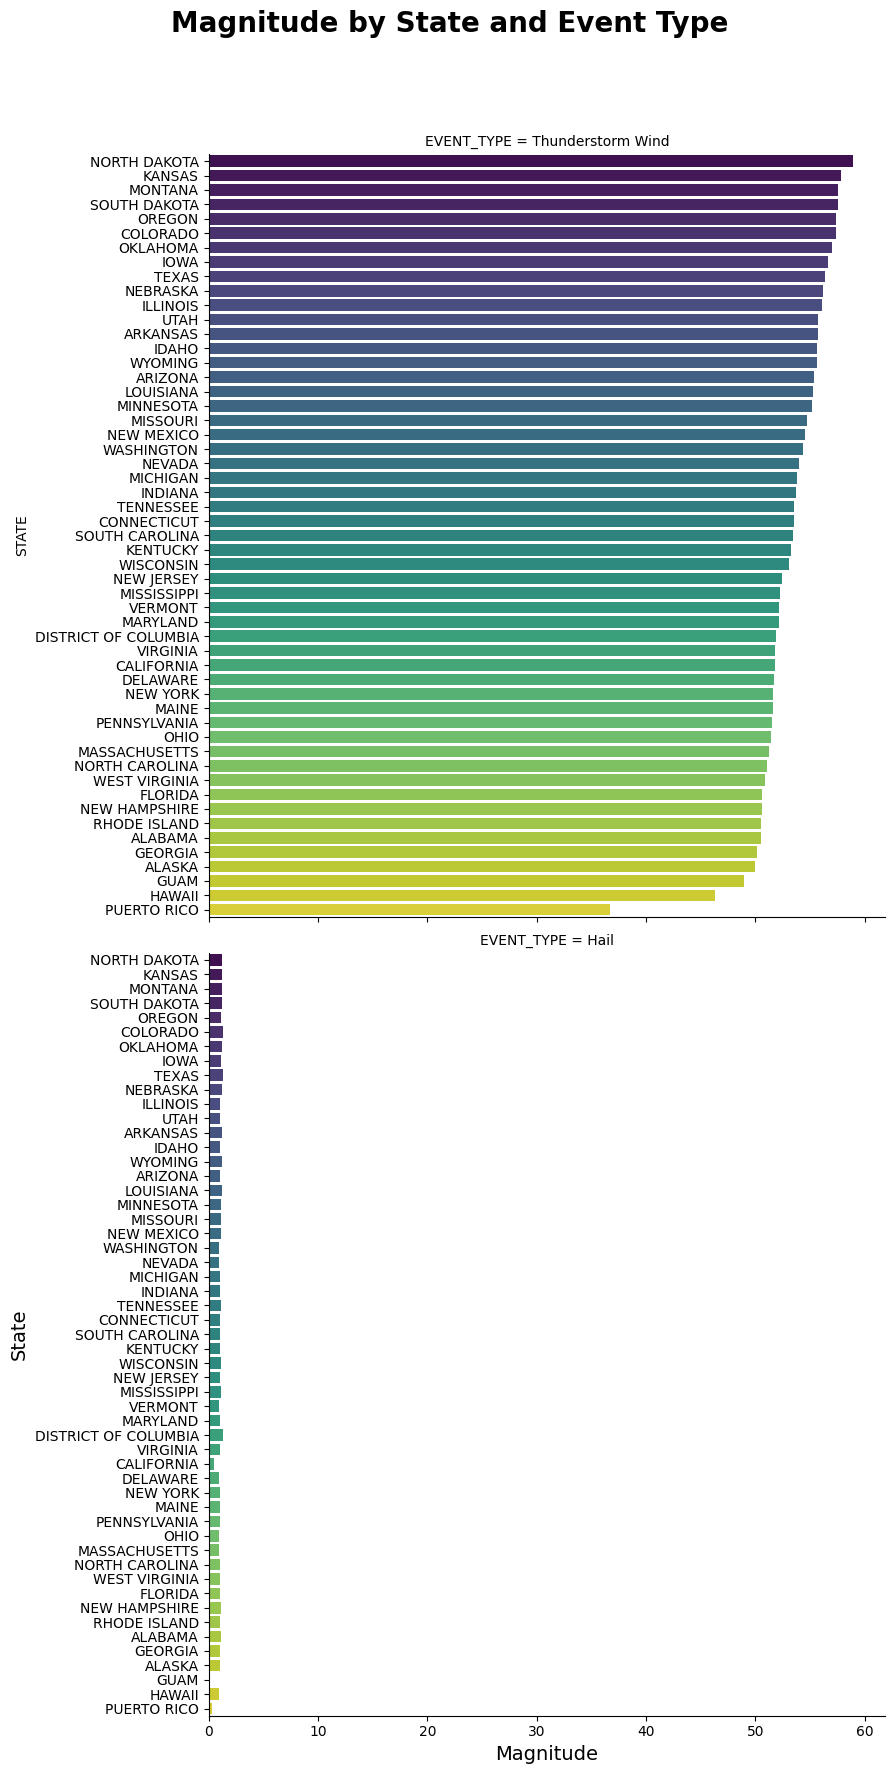

In [72]:
sorted_data = df.groupby(['EVENT_TYPE', 'STATE'], as_index=False)['MAGNITUDE'].mean().sort_values(by = "MAGNITUDE", ascending=False)
sns.catplot(
    data=sorted_data,
    y="STATE",
    hue="STATE",
    x="MAGNITUDE",           
    col="EVENT_TYPE",        
    kind="bar",             
    height=9,               
    aspect=1,             
    palette="viridis",       
    errorbar=None,
    legend = False,
    col_wrap=1
)
plt.subplots_adjust(top=0.9)  
plt.suptitle("Magnitude by State and Event Type", fontsize=20, fontweight='bold')
plt.xlabel("Magnitude", fontsize=14)
plt.ylabel("State", fontsize=14)
plt.show()

#### Feature Engineering
+ We create columns that represents more useful data injected in our Machine Learning algorithms.

In [73]:
df["BEGIN_DATE_TIME"] = pd.to_datetime(df["BEGIN_DATE_TIME"], format='%d-%b-%y %H:%M:%S')
df["END_DATE_TIME"] = pd.to_datetime(df["END_DATE_TIME"], format='%d-%b-%y %H:%M:%S')

In [74]:
df["DISASTER_DURATION"] = (df["END_DATE_TIME"] - df["BEGIN_DATE_TIME"]).dt.total_seconds() / 3600 # Extracting hours

#### Mapping Each Month to Its Corresponding Season


In [75]:
# Define the mapping of months to seasons
season_mapping = {
    'December': 'Winter', 'January': 'Winter', 'February': 'Winter',
    'March': 'Spring', 'April': 'Spring', 'May': 'Spring',
    'June': 'Summer', 'July': 'Summer', 'August': 'Summer',
    'September': 'Fall', 'October': 'Fall', 'November': 'Fall'
}

# Assign seasons based on the MONTH_NAME column
df['SEASONS'] = df['MONTH_NAME'].map(season_mapping)

#### Dropping descriptive columns not suitable for machine learning

In [76]:
cols_dropped_2 = ['MONTH_NAME', 
                'END_LOCATION',
                'END_AZIMUTH',
                'BEGIN_LOCATION',
                'END_DATE_TIME',
                'CZ_TIMEZONE',
                'WFO',
                'CZ_TYPE',
                'MONTH_NAME',
                'STATE'
                ]

Additional columns one may want to drop or not

In [51]:
cols_dropped_2.extend(['BEGIN_DATE_TIME','BEGIN_AZIMUTH',])

In [77]:
df = df.drop(cols_dropped_2, axis=1)

#### Assigning numerical intensity levels based on event type and magnitude

In [78]:
def classify_magnitude(row):
    """
    Classifies MAGNITUDE INTENSITY based on EVENT_TYPE and MAGNITUDE values.

    - Hail:
      - > 2 inches → 2 (High)
      - 1 - 2 inches → 1 (Moderate)
      - < 1 inch → 0 (Low)
    
    - Thunderstorm Wind:
      - > 75 mph → 2 (High)
      - 50 - 75 mph → 1 (Moderate)
      - < 50 mph → 0 (Low)
    """
    if row['EVENT_TYPE'] == 'Hail':
        if row['MAGNITUDE'] > 2:
            return 2  # Élevée
        elif row['MAGNITUDE'] >= 1:
            return 1  # Modérée
        elif row['MAGNITUDE'] < 1:
            return 0  # Faible

    elif row['EVENT_TYPE'] == 'Thunderstorm Wind':
        if row['MAGNITUDE'] > 75:
            return 2  # Élevée
        elif 50 <= row['MAGNITUDE'] <= 75:
            return 1  # Modérée
        elif row['MAGNITUDE'] < 50:
            return 0  # Faible

    return None  # If EVENT_TYPE is not recognized

# Apply the function to your DataFrame
df['MAGNITUDE INTENSITY'] = df.apply(classify_magnitude, axis=1)

# Dropping the original MAGNITUDE column after classification
df.drop(columns=['MAGNITUDE'], inplace=True)


Optionnal saving to csv for later use

In [55]:
#df.to_csv("storm_data_cleaned.csv")

## Some Usefull EDA

In [79]:
data = df 

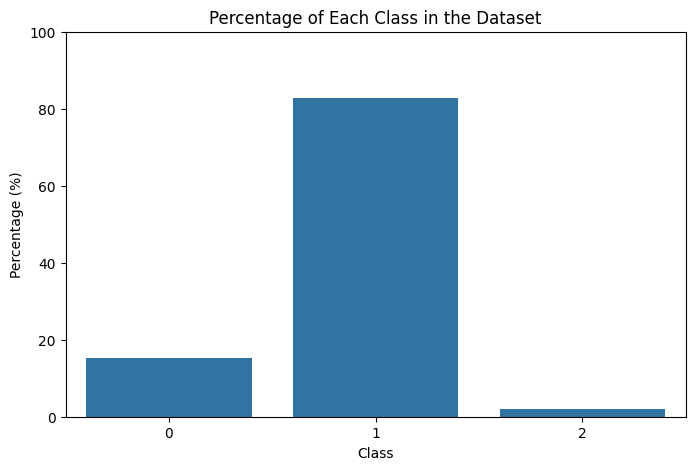

MAGNITUDE INTENSITY
1    82.763160
0    15.123955
2     2.112885
Name: proportion, dtype: float64


In [81]:
class_counts = data["MAGNITUDE INTENSITY"].value_counts(normalize=True) * 100 


plt.figure(figsize=(8, 5))
sns.barplot(x=class_counts.index, y=class_counts.values)


plt.xlabel("Class")
plt.ylabel("Percentage (%)")
plt.title("Percentage of Each Class in the Dataset")
plt.ylim(0, 100)
plt.show()
print(class_counts)

## Machine Learning

In [83]:
# Import necessary libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.metrics import accuracy_score, classification_report, f1_score
from scipy.stats import loguniform
from sklearn.dummy import DummyClassifier

In [84]:
def get_splits(data):
    X = data.drop("MAGNITUDE INTENSITY", axis=1)
    y = data["MAGNITUDE INTENSITY"]
    splits = train_test_split(X, y, test_size=0.2, random_state=42)
    return splits 

### Dummy Classifier for benchmark

In [85]:
X_train, X_test, y_train, y_test = get_splits(data)

In [86]:
dummy = DummyClassifier(strategy="most_frequent")

dummy.fit(X_train, y_train)

dummy_preds = dummy.predict(X_test)

print(f"Dummy accuracy: {accuracy_score(y_test, dummy_preds)}")
print(f"Dummy f1 score: {f1_score(y_test, dummy_preds, average='macro')}") # Compute f1 score per class then average equally

Dummy accuracy: 0.8297872340425532
Dummy f1 score: 0.3023255813953488


### Logistic Regression

In [212]:
# Encode categorical columns
le_event = LabelEncoder()
df['EVENT_TYPE'] = le_event.fit_transform(df['EVENT_TYPE'])

le_seasons = LabelEncoder()
df['SEASONS'] = le_seasons.fit_transform(df['SEASONS'])

# Select features and target
X = df[['STATE_FIPS', 'EVENT_TYPE', 'CZ_FIPS', 'DISASTER_DURATION', 'SEASONS']]
y = df['MAGNITUDE INTENSITY']

# Standardize the numeric features
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Split the data into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define a broader search space for hyperparameter tuning
param_dist = {
    'C': loguniform(0.0001, 1000),  # Try a wider range of regularization strengths
    'solver': ['lbfgs', 'saga', 'saga'],  # Test different solvers
    'multi_class': ['ovr', 'multinomial']
}

# Initialize the logistic regression model
log_reg = LogisticRegression(max_iter=100000)

# Perform RandomizedSearchCV to explore a broader range of hyperparameters
random_search = RandomizedSearchCV(log_reg, param_distributions=param_dist, 
                                   n_iter=100, cv=10, scoring='accuracy', n_jobs=-1, verbose=1, random_state=42)
random_search.fit(X_train, y_train)

# Get the best parameters and model
best_params = random_search.best_params_
best_model = random_search.best_estimator_

# Make predictions on the test set using the best model
y_pred = best_model.predict(X_test)

# Evaluate the best model
accuracy = accuracy_score(y_test, y_pred)
print(f'Best Parameters Found: {best_params}')
print(f'Best Accuracy on Validation Set: {random_search.best_score_}')
print(f'Test Set Accuracy: {accuracy}')
print(f'Classification Report:\n{classification_report(y_test, y_pred)}')

Fitting 10 folds for each of 100 candidates, totalling 1000 fits
Best Parameters Found: {'C': 0.041858227295469716, 'multi_class': 'ovr', 'solver': 'saga'}
Best Accuracy on Validation Set: 0.8270810878970994
Test Set Accuracy: 0.8297872340425532
Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      3187
           1       0.83      1.00      0.91     17901
           2       0.00      0.00      0.00       485

    accuracy                           0.83     21573
   macro avg       0.28      0.33      0.30     21573
weighted avg       0.69      0.83      0.75     21573



/Users/abedelzubaidi/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/abedelzubaidi/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/abedelzubaidi/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
